In [29]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.close_figures=False 

import os, sys
sys.path.append(os.path.abspath(os.path.join('../')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn import linear_model
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns 
from mlmodels.model import *
from mlmodels.linear_models import *
from mlmodels.treebased_models import *
from mlmodels.pca_selection import *
from mlmodels.lasso_selection import *
from helper_libraries.model_pipeline import *
from helper_libraries.forecasting_tools import *
from helper_libraries.preprocessing_tools import *
from tqdm.auto import tqdm
import datetime as dt
import sklearn.preprocessing
import sklearn.utils
import logging
import logging.config
import warnings

sns.set_context("paper", font_scale=1.7)
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Outline

* Load some sample data for testing
* Run tests on various classes and functions

# Prepare Logger

In [36]:
import logging
from tqdm import trange
from tqdm.contrib.logging import logging_redirect_tqdm

LOG = logging.getLogger(__name__)

if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO)
    with logging_redirect_tqdm():
        for i in trange(9):
            if i == 4:
                LOG.info("console logging redirected to `tqdm.write()`")
    # logging restored


100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 146882.24it/s]


In [33]:
# Start logging
log_filename = f"../logs/{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}_test_postselection.log"
logging.config.fileConfig("../_config/logging.conf", defaults={'log_filename': log_filename})

In [34]:
logging.warning('2ahh')

[2021-12-02 20:10:18,376] — [2084761215      - <module>    ] — [WARNING  — Line    1]: 2ahh


In [35]:
logging.info('ahh')

[2021-12-02 20:10:18,785] — [616219492       - <module>    ] — [INFO     — Line    1]: ahh


In [22]:
logging.debug('ahh')

In [ ]:
logger.

In [28]:
logger = logging.getLogger('__main__')
logger.name

'__main__'

In [6]:
# # Formatting for log messages
# log_format = "[{asctime}] — [{module:15.15} - {funcName:12.12}] — [{levelname:<8s} — Line {lineno:4d}]: {message}"
# formatter = logging.Formatter(fmt=log_format, datefmt="%Y-%m-%d %H:%M:%S", style="{")


# # Add a StreamHandler and FileHandler that outputs nicely formatted messages
# stream_handler = logging.StreamHandler()
# stream_handler.setFormatter(formatter)
# file_handler = logging.FileHandler("tests_postselection.log", mode="w")
# file_handler.setFormatter(formatter)

# # Logging level debug will output practically everything
# logging.basicConfig(
#     level=logging.DEBUG,
#     format=log_format,
#     datefmt="%Y-%m-%d %H:%M:%S",
#     style="{",
#     handlers=[stream_handler, file_handler],
# )

# # Will capture warnings and format them into the log
# logging.captureWarnings(True)

# # Name of logger is name of the script
# logger = logging.getLogger(__name__)

# # # This line is actually unnecssary if you only run this cell once
# # # Otherwise, want to prevent duplicate handlers so clear existing ones
# # logger.handlers.clear()
# # logger.addHandler(stream_handler)
# # logger.addHandler(file_handler)

# # # Add a StreamHandler that deals with warnings
# # logging.getLogger("py.warnings").handlers.clear()
# # stream_handler = logging.StreamHandler()
# # stream_handler.setFormatter(formatter)
# # file_handler = logging.FileHandler("tests_postselection.log", mode = 'w')
# # file_handler.setFormatter(formatter)

# # logging.getLogger("py.warnings").addHandler(stream_handler)
# # logging.getLogger("py.warnings").addHandler(file_handler)

# # # Prevent logger from sending messages to the root ( will give duplicate messages )
# # logger.propagate = False

# Load Data

In [7]:
# Set up some sample data for the tests
sample_data_df = pd.read_parquet('../../data/proc/_temp/1996_all.parquet')
print(os.getcwd())
# Load data
iris_df = sns.load_dataset('iris')
iris_df.head()

/mnt/c/Users/Saketh/Documents/Dropbox/HFML/code/tests


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Tests - Post Selection

## Set up high-dimensional data

The original columns are X = (petal width, sepal length, and sepal width)
The new columns are 
$$ X * H + \varepsilon$$
where $H$ is a rotation matrix (invertible with probabiltiy one actualy) obtained from a $3 \times 3$ matrix consisting of $U(0,1)$ entires and $\varepsilon$ consists of entries from $U(-5, 5)$. 

Also define new dependent variable Y as a rotation of the true X variables. 

In [8]:
# Copy the iris data set and add a bunch of noisy columns based on
# rotations of the original columns plus noise
np.random.seed(1)
iris_hf_df = iris_df.copy()
K = 150
X_new_cols = []
for k in range(K):
    new_col_names = [f"petal_width_{k}", f"sepal_length_{k}", f"sepal_width_{k}"]
    iris_hf_df[new_col_names] = (
        iris_hf_df[["petal_width", "sepal_length", "sepal_width"]] @ np.random.rand(3, 3)
        + (np.random.rand(len(iris_hf_df), 3) - 0.5) * 30
    )
    X_new_cols.append(new_col_names)
    
iris_hf_df['petal_length'] = iris_hf_df[["petal_width", "sepal_length", "sepal_width"]] @ np.random.rand(3, 1)

X_new_cols = sum(X_new_cols, [])

In [9]:
# Set up INS/OOS sample data
np.random.seed(1)
ins_frac = 0.1
iris_ins_df = iris_hf_df.sample(70).reset_index(drop = True)
iris_oos_df = iris_hf_df.sample(70).reset_index(drop = True)

Y_ins = iris_ins_df[['petal_length']]
X_ins = iris_ins_df[X_new_cols]
Y_oos = iris_oos_df[['petal_length']]
X_oos = iris_oos_df[X_new_cols]

DatetimeIndex(['2021-12-02', '2021-12-03', '2021-12-04', '2021-12-05',
               '2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
               '2021-12-10', '2021-12-11',
               ...
               '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24',
               '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28',
               '2022-04-29', '2022-04-30'],
              dtype='datetime64[ns]', length=150, freq='D')

In [12]:
## Estimate
# Here, I use [standard lasso] and compare with [pca -> lasso]

# Component algos
model_forecast_lasso = LASSO({"lambda": 1e-5, "use_intercept": False, "seed": 5}, n_iter=12)
model_forecast_enet = ENet(
    {"lambda": 1e-5, "l1_ratio": 0.5, "use_intercept": True, "seed": 5}, n_iter=14
)
model_forecast_ols = LinearRegression({})
model_selection_pca = PCA_selection({})
model_selection_lasso = LASSO_selection({})

# Post-selection algos
model_pca_lasso = PostSelectionModel(model_selection_pca, model_forecast_lasso, n_iter=58)
model_lasso_ols = PostSelectionModel(model_selection_lasso, model_forecast_ols)
model_pca_enet = PostSelectionModel(model_selection_pca, model_forecast_enet)
model_list = [model_forecast_lasso, model_pca_lasso, model_lasso_ols, model_pca_enet]

# Split into train/validate for optimal hyperparams
mtrain = ModelTrainer(model_list, Y_ins, X_ins, seed=444)
mtrain.validation(frac=0.5, n_iter_default=100)

# Testing
mtest = ModelTester(mtrain)
model_forecasts, model_params = mtest.forecast(Y_oos, X_oos)

[2021-12-02 14:50:40,333] — [model_pipeline  - validation  ] — [INFO     — Line  118]: Validating Lasso
[2021-12-02 14:50:40,369] — [linear_models   - fit         ] — [WARNING  — Line  101]: LASSO Convergence Warning
[2021-12-02 14:50:40,429] — [linear_models   - fit         ] — [WARNING  — Line  101]: LASSO Convergence Warning
[2021-12-02 14:50:40,480] — [linear_models   - fit         ] — [WARNING  — Line  101]: LASSO Convergence Warning
[2021-12-02 14:50:40,543] — [linear_models   - fit         ] — [WARNING  — Line  101]: LASSO Convergence Warning
[2021-12-02 14:50:40,619] — [linear_models   - fit         ] — [WARNING  — Line  101]: LASSO Convergence Warning
[2021-12-02 14:50:40,648] — [model_pipeline  - validation  ] — [INFO     — Line  118]: Validating PostSelectionModel(PCA_selection -> Lasso)
[2021-12-02 14:50:41,372] — [model_pipeline  - validation  ] — [INFO     — Line  118]: Validating PostSelectionModel(Lasso_selection -> LR)
[2021-12-02 14:50:41,398] — [lasso_selection - fit

## View results

In [31]:
def view_results(model_index):
    
    results_df = pd.concat(
        [
            model_forecasts[model_index].rename(columns={"petal_length": "forecast"}),
            Y_oos.rename(columns={"petal_length": "true"})
        ],
        axis=1,
    )

    display(smf.ols('true ~ forecast - 1', data = results_df).fit().summary())

    fig, ax = plt.subplots(figsize = (5,5))
    sns.regplot(x = 'forecast', y = 'true', data = results_df, ax  = ax)

### Pure Lasso

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   true   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              5072.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):                    2.48e-66
Time:                        22:31:00   Log-Likelihood:                         -12.539
No. Observations:                  70   AIC:                                      27.08
Df Residuals:                      69   BIC:                                      29.33
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
forecast       1.0150      0.014     71.216      0.000       0.987       1.043
==============================================================================
Omnibus:                        3.685   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                3.021
Skew:                           0.498   Prob(JB):                        0.221
Kurtosis:                       3.207   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

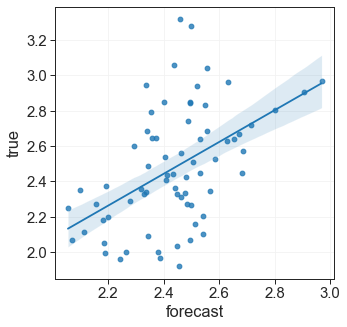

In [12]:
view_results(0)

### PCA Lasso

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   true   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              5210.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):                    9.89e-67
Time:                        22:31:00   Log-Likelihood:                         -11.608
No. Observations:                  70   AIC:                                      25.22
Df Residuals:                      69   BIC:                                      27.46
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
forecast       0.9860      0.014     72.182      0.000       0.959       1.013
==============================================================================
Omnibus:                        4.532   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                3.690
Skew:                           0.524   Prob(JB):                        0.158
Kurtosis:                       3.407   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

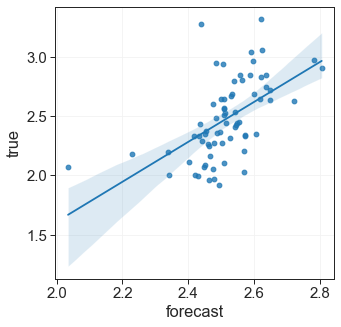

In [13]:
view_results(1)

### Lasso OLS

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   true   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              5949.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):                    1.08e-68
Time:                        22:31:00   Log-Likelihood:                         -7.0265
No. Observations:                  70   AIC:                                      16.05
Df Residuals:                      69   BIC:                                      18.30
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
forecast       0.9900      0.013     77.127      0.000       0.964       1.016
==============================================================================
Omnibus:                        3.722   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.921
Skew:                           0.366   Prob(JB):                        0.232
Kurtosis:                       3.682   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

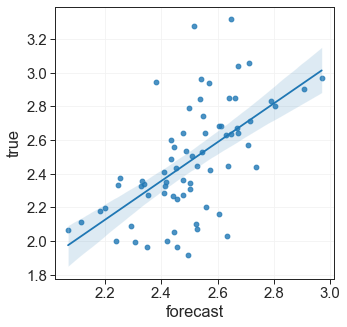

In [14]:
view_results(2)

### PCA Enet

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   true   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              5212.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):                    9.79e-67
Time:                        22:31:00   Log-Likelihood:                         -11.597
No. Observations:                  70   AIC:                                      25.19
Df Residuals:                      69   BIC:                                      27.44
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
forecast       0.9860      0.014     72.193      0.000       0.959       1.013
==============================================================================
Omnibus:                        4.541   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                3.697
Skew:                           0.525   Prob(JB):                        0.157
Kurtosis:                       3.408   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

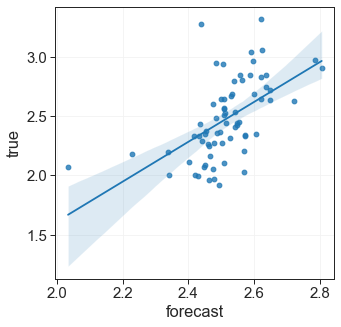

In [15]:
view_results(3)

### Do the estimates make sense?

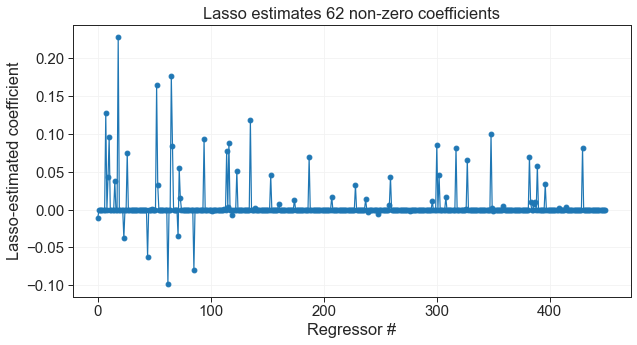

In [16]:
# Params for just Lasso
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(model_params[0], marker = 'o')
ax.set_xlabel('Regressor #')
ax.set_ylabel('Lasso-estimated coefficient')
ax.set_title(f'Lasso estimates {np.sum(model_params[0] != 0)} non-zero coefficients');

In [17]:
# Params for PCA then Lasso
display(model_params[1])
print()
print(f'PCA picks {np.sum(model_params[1]["selection"] != 0)} components');
print(f'... then Lasso estimates {np.sum(model_params[1]["forecast"] != 0)} non-zero coefficients');

{'selection': array([26.91518839, 26.38009029, 26.03910239, 25.0195231 , 24.92304903,
        24.58767222, 24.54416499, 23.95940977, 23.7190268 ]),
 'forecast': array([-0.05405032,  0.00115788,  0.12039388, -0.04603717, -0.00483789,
         0.0354423 , -0.02827933, -0.06893729, -0.10070204])}


PCA picks 9 components
... then Lasso estimates 9 non-zero coefficients


In [18]:
# Params for Lasso then OLS
# display(model_params[2])
print()
print(f'Lasso picks {np.sum(model_params[2]["selection"] != 0)} components');
print(f'... then OLS estimates {np.sum(model_params[2]["forecast"] != 0)} non-zero coefficients');


Lasso picks 300 components
... then OLS estimates 301 non-zero coefficients


In [19]:
# Params for PCA then Enet
display(model_params[3])
print()
print(f'PCA picks {np.sum(model_params[3]["selection"] != 0)} components');
print(f'... then Enet estimates {np.sum(model_params[3]["forecast"] != 0)} non-zero coefficients');

{'selection': array([26.91518839, 26.38009029, 26.03910239, 25.0195231 , 24.92304903,
        24.58767222, 24.54416499, 23.95940977, 23.7190268 ]),
 'forecast': array([-0.05414261,  0.0012544 ,  0.12049191, -0.04614406, -0.00494599,
         0.03555307, -0.02839056, -0.06905361, -0.1008204 ])}


PCA picks 9 components
... then Enet estimates 9 non-zero coefficients
